## **Introduction**

Crime in New York City has always been a concern, especially the shooting incidents, which takes many lives every year. Indeed, with the introduction of many policies that benefit the people and the development of the economy, the overall number of shooting incidents in New York has continued to decline since the beginning of this century. But there is still an overall high number of crimes. 

Therefore, I want to make this project to analyze the variation trend of shooting incidents in New York City every year and every hour since 2006, as well as the spatial analysis of the relationship between deterrence range of Brooklyn police stations and the distribution of shooting incidents.


Data:
  * [shooting incidents in New York from 2006 to 2020](https://data.cityofnewyork.us/Public-Safety/NYPD-Shooting-Incident-Data-Historic-/833y-fsy8)
  * Census blocks in New York used in class

*   Connecting to google drive, installing and importing modules.

In [109]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [110]:
import os
os.chdir('/content/drive/MyDrive/GEOG363/Code/')

In [111]:
!pip install geopandas
!pip install osmnx
!pip install matplotlib==3.1.3
!pip install folium --upgrade

  Using cached matplotlib-3.5.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


/usr/local/lib/python3.7/dist-packages/google/colab/_pip.py:87: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.7/dist-packages/matplotlib-3.5.1.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
  for line in open(toplevel):


  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osmnx 1.1.2 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


/usr/local/lib/python3.7/dist-packages/google/colab/_pip.py:87: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.7/dist-packages/matplotlib-3.1.3.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
  for line in open(toplevel):


In [112]:
import pandas as pd
import geopandas as gpd
import folium
import osmnx as ox
import matplotlib.pyplot as plt
from folium.plugins import HeatMapWithTime

# **Problem 1: Creat several time series graphs and heat map for shooting incidents**

### **Part 1: Grouping the data**

*   Read two needed files

In [113]:
# Read the census_block geopandas dataframe
census_block = gpd.read_file('nyc_shapefiles/nyc_census_blocks.shp')

# Read the csv file and select specified columns
shooting_incident = pd.read_csv('NYPD_Shooting_Incident_Data__Historic_.csv',
                  usecols = ['INCIDENT_KEY','OCCUR_DATE','OCCUR_TIME','BORO','Latitude','Longitude','Lon_Lat'])
shooting_incident.head()

INCIDENT_KEY  OCCUR_DATE OCCUR_TIME      BORO   Latitude  Longitude  \
0      24050482  08/27/2006   05:35:00     BRONX  40.869058 -73.879632   
1      77673979  03/11/2011   12:03:00    QUEENS  40.677367 -73.843920   
2     203350417  10/06/2019   01:09:00  BROOKLYN  40.674886 -73.960075   
3      80584527  09/04/2011   03:35:00     BRONX  40.808798 -73.916184   
4      90843766  05/27/2013   21:16:00    QUEENS  40.597796 -73.794686   

                                         Lon_Lat  
0   POINT (-73.87963173099996 40.86905819000003)  
1  POINT (-73.84392019199998 40.677366895000034)  
2  POINT (-73.96007501899999 40.674885741000026)  
3   POINT (-73.91618413199996 40.80879780500004)  
4  POINT (-73.79468553799995 40.597796249000055)

*   Modify the column ```BORO``` in ```shooting_incident``` in order to match the column ```BORONAME``` in ```census_block```.

In [114]:
# Change the BRONX in BORO column to THE BRONX
shooting_incident['BORO'] = shooting_incident['BORO'].replace(['BRONX'],'THE BRONX')

# Capitalize every word in BORO column
shooting_incident['BORO'] = shooting_incident['BORO'].str.title()

# Change the name of BORO column to BORONAME
shooting_incident = shooting_incident.rename(columns={'BORO':'BORONAME'})

shooting_incident.head()

INCIDENT_KEY  OCCUR_DATE OCCUR_TIME   BORONAME   Latitude  Longitude  \
0      24050482  08/27/2006   05:35:00  The Bronx  40.869058 -73.879632   
1      77673979  03/11/2011   12:03:00     Queens  40.677367 -73.843920   
2     203350417  10/06/2019   01:09:00   Brooklyn  40.674886 -73.960075   
3      80584527  09/04/2011   03:35:00  The Bronx  40.808798 -73.916184   
4      90843766  05/27/2013   21:16:00     Queens  40.597796 -73.794686   

                                         Lon_Lat  
0   POINT (-73.87963173099996 40.86905819000003)  
1  POINT (-73.84392019199998 40.677366895000034)  
2  POINT (-73.96007501899999 40.674885741000026)  
3   POINT (-73.91618413199996 40.80879780500004)  
4  POINT (-73.79468553799995 40.597796249000055)

*   Change the ```OCCUR_DATE``` column of ```shooting_incident``` to datatime format

In [115]:
# Set the 'OCCUR_DATE' as index column
shooting_incident2 = shooting_incident.set_index('OCCUR_DATE')

# Change the data type of 'OCCUR_DATE' column to string
shooting_incident2['OCCUR_DATE'] = shooting_incident2.index.astype(str)

# Change the column to datetime
shooting_incident2['OCCUR_DATE'] = pd.to_datetime(shooting_incident2['OCCUR_DATE'],format='%m/%d/%Y')
shooting_incident2['OCCUR_TIME'] = pd.to_datetime(shooting_incident2['OCCUR_TIME'],format='%H:%M:%S')

*   Grouping the ```shooting_incident_gb_year``` by ```year``` column



In [116]:
# Extract Year from the datetime column to a new column
shooting_incident2['year'] = shooting_incident2['OCCUR_DATE'].apply(lambda x: x.strftime('%Y'))

# Create a copy of shooting_incident dataframe 
shooting_incident_gb_year = shooting_incident2.copy()

# Add a new column and set the value to 1
shooting_incident_gb_year['shooting_incident'] = 1

# Use groupby() and count() to conclude the shooting incident by year
shooting_incident_gb_year = shooting_incident_gb_year[['year','shooting_incident']].groupby('year').count()

*   Grouping the ```shooting_incident_gb_hour``` by ```hour``` column

In [117]:
# Extract hour from the datetime column to a new column
shooting_incident2['hour'] = shooting_incident2['OCCUR_TIME'].apply(lambda x: x.strftime('%H'))

# Create a copy of shooting_incident dataframe 
shooting_incident_gb_hour = shooting_incident2.copy()

# Add a new column and set the value to 1
shooting_incident_gb_hour['shooting_incident'] = 1

# Use groupby() and count() to conclude the shooting incident by hour
shooting_incident_gb_hour = shooting_incident_gb_hour[['hour','shooting_incident']].groupby('hour').count()

*   Grouping the ```shooting_incident_stacked``` by ```year``` and ```hour``` columns

In [118]:
# Create a copy of shooting_incident dataframe 
shooting_incident_stacked = shooting_incident2.copy()

# Add a new column and set the value to 1
shooting_incident_stacked['shooting_incident'] = 1

# Use groupby() and count() to conclude the shooting incident by both hour and year
shooting_incident_stacked = shooting_incident_stacked.groupby(['year','hour'])['shooting_incident'].count()

# Save the shooting_incident_stacked to a csv file
shooting_incident_stacked.to_csv("shooting_incident_stacked.csv")

# Read the shooting_incident_stacked
shooting_incident_stacked = pd.read_csv('shooting_incident_stacked.csv')

# Unstack the year column
shooting_incident_stacked = shooting_incident_stacked.set_index(['hour','year'])['shooting_incident'].unstack()

### **Part 2: Plot the annual and hourly shooting incidents and their combination**

*   The yearly trend line graph

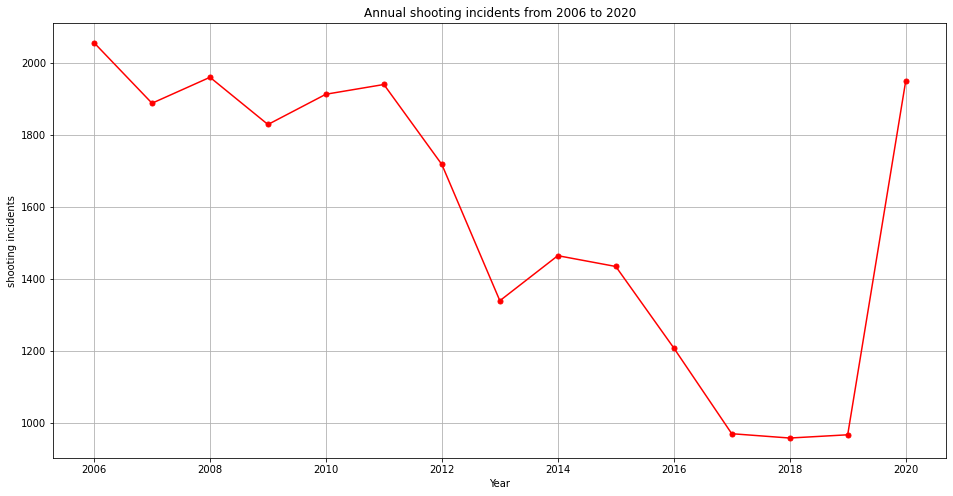

In [119]:
# Make the plot
ax = shooting_incident_gb_year['shooting_incident'].plot(style='r.-', title='Annual shooting incidents from 2006 to 2020', 
                figsize=(16,8), markersize = 10)

# Set the x and y labels
ax.set_xlabel('Year')
ax.set_ylabel('shooting incidents')

# Add the grid lines
plt.grid()

*   The hourly trend bar graph

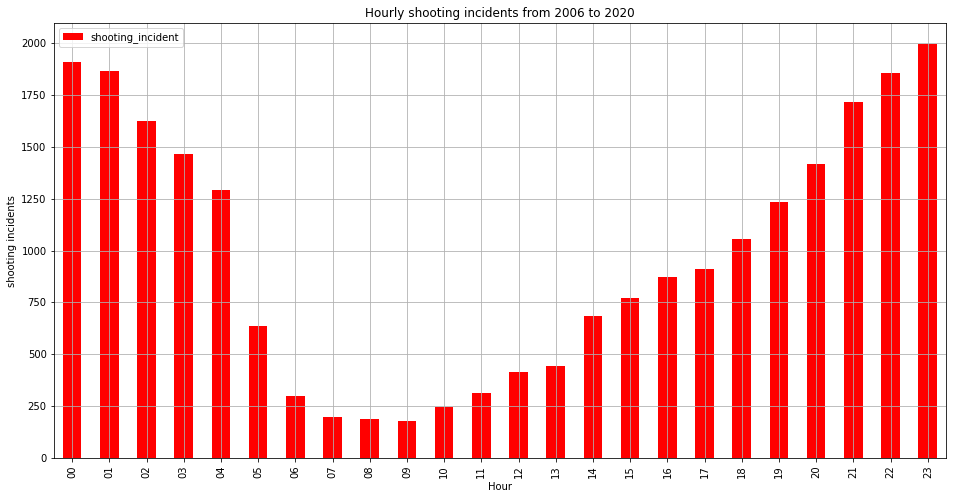

In [120]:
# Plot the bar graph
ax = shooting_incident_gb_hour.plot.bar(figsize=(16,8), color='red', title='Hourly shooting incidents from 2006 to 2020')

# Set the x and y labels
ax.set_xlabel('Hour')
ax.set_ylabel('shooting incidents')

# Add the grid lines
plt.grid()

*   The combined stacked bar graph

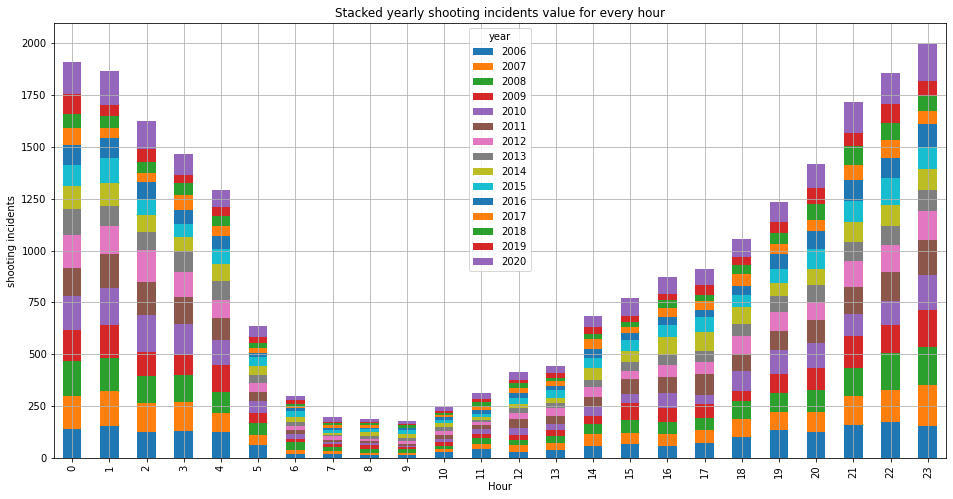

In [121]:
# Plot the stacked bar graph
ax = shooting_incident_stacked.plot.bar(figsize=(16,8), title='Stacked yearly shooting incidents value for every hour', stacked=True)

# Set the x and y labels
ax.set_xlabel('Hour')
ax.set_ylabel('shooting incidents')

# Add the grid lines
plt.grid()

### **Part 3: Plot the annual shooting incidents heatmap**

*   Create a three level latitude and longitude list: ```lat_lon_list```

In [122]:
# Create two empty lists
lat_lon_list = []
time_index = []

# Create an outer for loop to iterate through year index from 2006 to 2020 
for i in range(2006,2021,1):
  time_index.append(i)
  temp=[]
  
  # Create an inner for loop to iterate through OCCUR_DATE that equal to the year index
  for index, instance in shooting_incident2[shooting_incident2['OCCUR_DATE'].dt.year == i].iterrows():
      lat = instance['Latitude']
      lon = instance['Longitude']
      temp.append([lat,lon])
      
  lat_lon_list.append(temp)

*   Plot the heat map with time

In [123]:
# Create a Map instance
m = folium.Map(location=[40.71455, -73.86812], zoom_start=11, tiles = 'cartodbpositron')

# Plot the yearly heat map for shooting incidents
hm = HeatMapWithTime(lat_lon_list, auto_play = True, index=time_index, radius=6)
hm.add_to(m)

# Show the map
m

It can be seen that the overall number of shooting incidents in New York showed a downward trend from 2006 to 2019. This trend may be due to the increased supervision of the municipal government in order to combat crime, or it may also be due to the economic development. From 2019 to 2020, the number of shootings incidents soared, almost equal to that in 2008. The reason for this is COVID, the global pandemic, first began to rage in New York in the US, and the rise caused by social panic and unrest.

In addition, from the hourly data, shooting incidents occur frequently from evening to early morning every day, and less frequently during the day.



# **Problem 2 Analysing the spatial relationship between distribution of shooting incidents and police stations buffer zone**

### **Part 1: Make a choropleth map of shooting incidents within each borough**

*   Grouping the ```shooting_incident_gb_boro``` by ```BORONAME``` column

In [124]:
# Create a copy dataframe of shooting_incident
shooting_incident_gb_boro = shooting_incident.copy()

# Create a column with value 1
shooting_incident_gb_boro['shooting_incident'] = 1

# Group all shooting incidents by BORONAME
shooting_incident_gb_boro = shooting_incident_gb_boro[['BORONAME','shooting_incident']].groupby('BORONAME').count().reset_index()

shooting_incident_gb_boro

BORONAME  shooting_incident
0       Brooklyn               9734
1      Manhattan               2922
2         Queens               3532
3  Staten Island                696
4      The Bronx               6701

*   Dissolve all census blocks within each borough

In [125]:
# Use dissolve method to combine all census blocks within the same borough
boro_dissolved = census_block[['BORONAME','geometry']].dissolve(by='BORONAME').reset_index()
boro_dissolved

BORONAME                                           geometry
0       Brooklyn  MULTIPOLYGON (((582866.045 4495197.182, 582852...
1      Manhattan  MULTIPOLYGON (((582492.877 4504133.725, 582478...
2         Queens  MULTIPOLYGON (((589675.611 4509384.109, 589614...
3  Staten Island  MULTIPOLYGON (((564657.515 4483524.189, 564651...
4      The Bronx  MULTIPOLYGON (((590362.779 4517563.146, 590248...

*   Plot the choropleth map

In [126]:
# Create a Map instance
m = folium.Map(location=[40.71455, -73.86812], tiles = 'cartodbpositron',
    zoom_start=10, control_scale=True)

# Plot a choropleth map
folium.Choropleth(
    geo_data=boro_dissolved,
    name='Choropleth',
    data=shooting_incident_gb_boro,
    columns=['BORONAME','shooting_incident'],
    key_on='feature.properties.BORONAME',
    fill_color='YlOrRd',
    fill_opacity=0.8,
    line_opacity=0.2,
    line_color='white', 
    line_weight=0,
    highlight=True,
    smooth_factor=1.0,
    bins=4,
    legend_name= 'Shooting Incident in New York City').add_to(m)

folium.LayerControl().add_to(m)

# Show the map
m

Brooklyn has the most shootings events from 2006 to 2020. Therefore, I will continue to analyze the relationship between the shooting incidents density in Brooklyn and the buffer zone created by the reasonable deterrence range of the police station.




### **Part 2: Focused on Brooklyn, I will import osmnx to find all police stations**


*   Extract and process all police stations by using osmnx

In [127]:
# Locate the place
place_name = 'Brooklyn, Kings County, New York, United States'

# Fetch OSM street network from the location
area = ox.geocode_to_gdf(place_name)

In [128]:
# Create a tag that select amenities named police
tag = {'amenity': 'police'}

# Retrieve all police stations
police_stations = ox.geometries_from_place(place_name, tag)

In [129]:
# select only the geometry column
cols = ['geometry']

# Select only police stations points and reset the index column
police_stations = police_stations[cols].reset_index()

# Reproject the crs to match the census_block geodataframe
police_stations = police_stations.to_crs('epsg:26918')

*   Get centroid for all police stations

In [130]:
police_stations['geometry'] = police_stations.centroid
police_stations.head()

element_type       osmid                        geometry
0         node   368051847  POINT (588393.205 4508950.135)
1         node   368051882  POINT (585917.993 4505439.787)
2         node   368051892  POINT (590882.003 4504866.201)
3         node   368051939  POINT (587643.103 4506772.766)
4         node  1314439274  POINT (587648.637 4503266.720)

### **Part 3: Creat buffer zones, all census blocks inside them, and points of shooting incidents in Brooklyn**


*   The 2000 meter buffer zone of the police station allows the police to respond in time to emergencies, so create buffer zone for all police stations

In [131]:
# Create buffer zone
police_stations['buffer'] = police_stations.buffer(distance=2000)

*   Extrac all census blocks in the buffer zone in ```census_block``` geodataframe

In [132]:
# Creat an empty list
within_census_block=[]

# iterate the police stations in the police_stations
for i in police_stations.index:

  # Extract the census blocks that within the police stations in police_stations geodataframe
  within = census_block.within(police_stations.at[i,'buffer'])

  # Extract the blkid for all within census blocks
  blkid = census_block.loc[within,'BLKID']

  # Append blkid to the list
  within_census_block.append(blkid.values)

*   Flatten the list ```within_census_block``` and process it



In [133]:
# flatten the list created above
flat_list = [a for i in within_census_block for a in i]

# Save the flatted list to a new dataframe
police_station_buffer = pd.DataFrame(flat_list)

# Remove all duplicated values in the dateframe
police_station_buffer = police_station_buffer.drop_duplicates()

# Determine all census blocks that in the flat_list above are whether in the census_block dataframe
police_station_buffer = census_block[census_block['BLKID'].isin(flat_list)]

*   Only show the buffer area in the Brooklyn

In [134]:
# Show the census blocks within buffer area in Brooklyn
police_station_buffer = police_station_buffer[police_station_buffer.BORONAME == 'Brooklyn']

* Extract all shooting incidents in brooklyn from ```shooting_incident``` dataframe and convert to a geodataframe

In [135]:
# Select shooting incidents only in the Brooklyn
shooting_incident_brooklyn = shooting_incident.loc[shooting_incident['BORONAME']=='Brooklyn']

# Only extract Latitude and Longitude columns
shooting_incident_brooklyn = shooting_incident_brooklyn[['Latitude','Longitude']]

# Conver the shooting_incident_brooklyn datafram to a new geodataframe
shooting_incident_brooklyn_gdf = gpd.GeoDataFrame(
                 shooting_incident_brooklyn, 
                 geometry=gpd.points_from_xy(shooting_incident_brooklyn.Longitude, shooting_incident_brooklyn.Latitude))

*   Set a projection and Re-project for the ```shooting_incident_brooklyn_gdf``` geodataframe

In [136]:
# Set the projection of the new created geodataframe
shooting_incident_brooklyn_gdf  = shooting_incident_brooklyn_gdf.set_crs('epsg:4326')

# Reproject the crs to match the census_block geodataframe
shooting_incident_brooklyn_gdf  = shooting_incident_brooklyn_gdf.to_crs('epsg:26918')

### **Part 4: Plot the buffer zone, points of shooting incidents, and police stations**

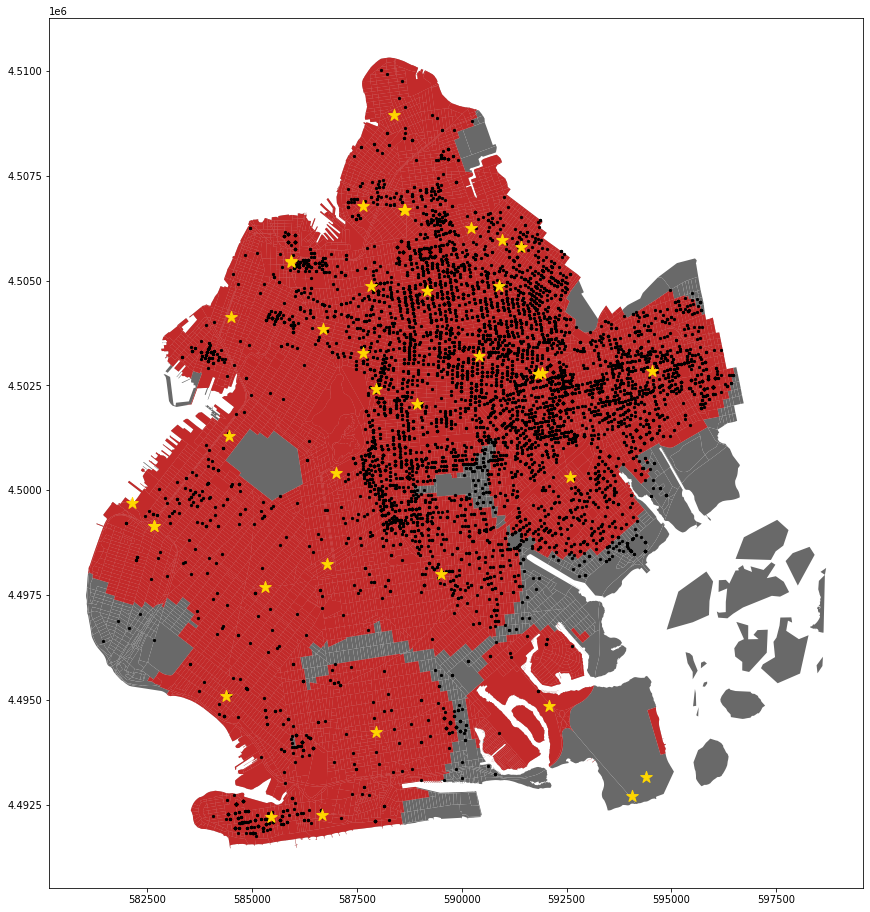

In [137]:
# Make a plot
fig, ax = plt.subplots(figsize=(16,16))

# Plot the census blocks in Brooklyn
census_block.loc[census_block['BORONAME']=='Brooklyn'].plot(ax=ax, facecolor='dimgray')

# Plot the buffer for police stations
police_station_buffer.plot(ax=ax, facecolor='red', alpha=0.6)

# Plot shooting incidents points
shooting_incident_brooklyn_gdf.plot(ax=ax, color='black', markersize=5)

# Plot the location of all police stations
police_stations['geometry'].plot(ax=ax, marker='*', color='gold', markersize=150)

Golden stars represent the distribution of all police stations in Brooklyn, black dots represent all shooting cases, and red areas represent the deterrence range of these police stations. Finally, we can see that Brooklyn, as the highest crime area in New York, has police stations with sufficient deterrence range in most places. However, there are still a few areas with relatively weak police force, especially a small gray area in the middle of Brooklyn, where there are a certain density of shootings, but there is a relative lack of police force.

# **Conclusion**
It can be seen that the shooting in New York is still a tough problem. Indeed, municipal government still need to enact a series of policies to benefit the people and strengthen the effective management of the police station to curb the shooting incidents.